In [1]:
import pyxdf
import mne
from mne.decoding import CSP
import numpy as np

In [2]:
# -- |Data details| --
participant_id = '00'
session = '01'

# -- |File import| --
streams, header = pyxdf.load_xdf(f"Data/sub-P0{participant_id}/ses-S0{session}/eeg/sub-P0{participant_id}_ses-S0{session}_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

# -- |EEG data| --
EEG = [data for data in streams if data['info']['type'] == ['EEG']][0] #From Steam variable this query is EEG data
raw_data = (EEG["time_series"].T)/1000000 # Convert microvoltage to voltage

# -- |Channels Information| --
channels = ['Fz','C3','Cz','C4','Pz','PO7','PO8','EOG'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
    sfreq= 250,  #OpenBCI Frequency acquistion
    verbose=False
)

# -- |Create MNE rawarray| --
raw_mne = mne.io.RawArray(raw_data, info, verbose=False)
raw_mne

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,"7 EEG, 1 EOG"
Bad channels,None
EOG channels,EOG
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39828\3792742955.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_mne.compute_psd(fmin=0,fmax=50).plot();
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39828\3792742955.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_mne.compute_psd(fmin=0,fmax=50).plot();
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


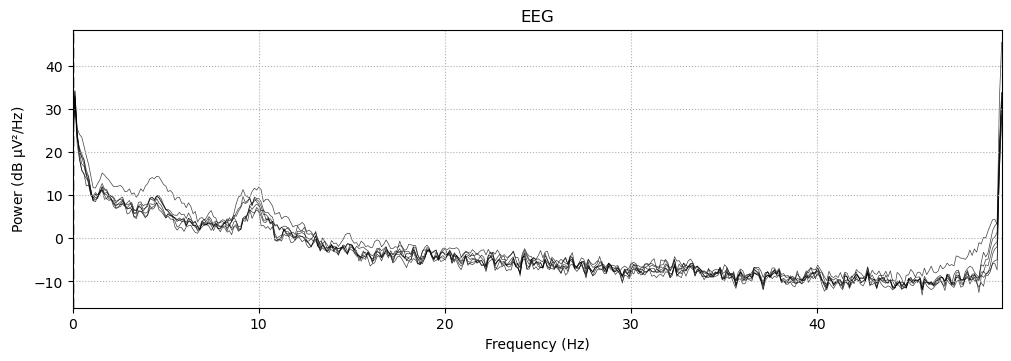

In [3]:
raw_mne.compute_psd(fmin=0,fmax=50).plot();

In [4]:
# -- |Common Average Reference| --
mne_car = raw_mne.copy().set_eeg_reference('average', verbose=False)

# -- |Bandpass filter| --
mne_alpha = mne_car.filter(l_freq=8.0, h_freq=13.0, fir_design='firwin', verbose=False)

# -- |Events|--
Events = [data for data in streams if data['info']['type'] == ['Markers']][0]

event_index = Events["time_series"].T[0] #Get all event marker of experiment 
event_timestamp = (((Events["time_stamps"].T) - EEG["time_stamps"][0]) *250).astype('int')

events = np.column_stack((np.array(event_timestamp, dtype = int),
                    np.zeros(len(event_timestamp), dtype = int),
                    np.array(event_index, dtype = int)))

# events_id = { # Set up your event name
#     'none': 0,
#     'right': 1,
#     'left':2
# }

events_id = { # Set up your event name
    'right': 0,
    'left':1
}

# -- |Epoch Segmentation| --
epochs = mne.Epochs(mne_alpha, events, 
    tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
    tmax= 3.0,      # final timestamp (10 means set epoch duration 10 second)
    event_id =events_id,
    preload = True,
    verbose=False,
    picks = ['C3','Cz','C4','PO7','Pz','PO8']
)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

epochs

Number of events,31
Events,left: 15right: 16
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


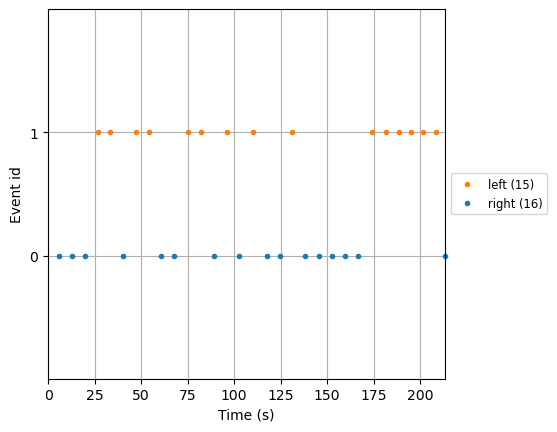

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_39828\1218563085.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [5]:
# Plotting events
fig = mne.viz.plot_events(
    events, sfreq=mne_alpha.info["sfreq"], first_samp=mne_alpha.first_samp, event_id= events_id
)
fig.show()

In [6]:
# Get EEG data and events
X = epochs.get_data(copy=False)
Y = epochs.events[:, -1]

print(f'EEG data shape: {X.shape}')
print(f'events shape  : {Y.shape}')

EEG data shape: (31, 6, 876)
events shape  : (31,)


Computing rank from data with rank=None
    Using tolerance 8.6e-07 (2.2e-16 eps * 6 dim * 6.5e+08  max singular value)
    Estimated rank (data): 6
    data: rank 6 computed from 6 data channels with 0 projectors
Reducing data rank from 6 -> 6
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


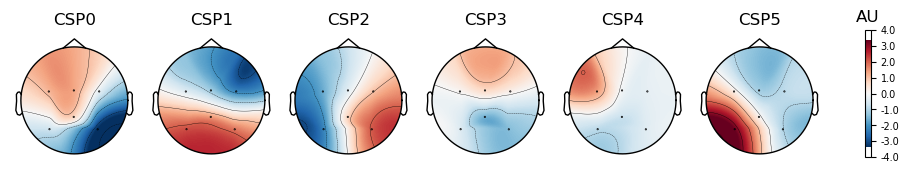

In [7]:
# Initilize CSP
csp = CSP(n_components = 6, norm_trace = False)

# Fit CSP to data 
csp.fit(X,Y)

# Visualize CSP patterns
csp.plot_patterns(epochs.info);